In [1]:
from datasets import SP500Dataset, train_test_split, TSDataset
from torch.utils.data import DataLoader
import torch
import torch.nn.functional as F
stock_dataset = SP500Dataset()
data_numpy = stock_dataset.get_data_numpy(log_return=False)
train_data, test_data = train_test_split(data_numpy, train_size=0.8)

window_size = 22 * 3
horizon = 22 
stride = 7
train_dataset = TSDataset(train_data, window_size, horizon, stride)
test_dataset = TSDataset(test_data, window_size, horizon, stride)
print('train samples: ', len(train_dataset), '\ntest samples: ', len(test_dataset))
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

train samples:  400 
test samples:  91


In [2]:
stock_dataset.get_names()[0]

'A'

Normalizing the data's variance...
436 nodes and 3604 time samples
Fitting the model...


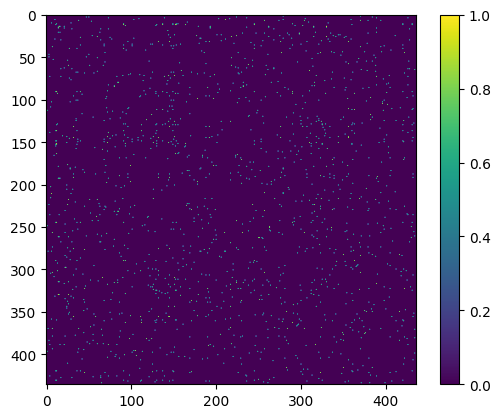

In [3]:
from construct_graph import GraphConstructor, draw_heat_map
gc = GraphConstructor(stock_dataset.get_data_numpy(log_return=True), alpha=0.2, max_iter=200)
# gc = GraphConstructor(train_data, alpha=0.2, max_iter=200)
tho_adj = 0.1
adj = gc.get_adjacency_matrix(tho_adj)
draw_heat_map(adj)

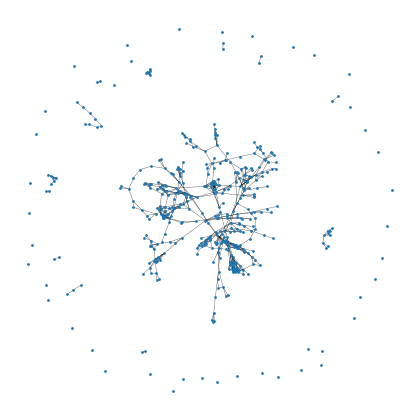

In [4]:
import matplotlib.pyplot as plt
import networkx as nx

adjacency_matrix = gc.get_adjacency_matrix(tho_adj)
G = nx.from_numpy_array(adjacency_matrix)
if len(gc.names) == gc.n:
    G = nx.relabel_nodes(G, dict(enumerate(gc.names)))
# pos = nx.spring_layout(G, k=0.2*1/np.sqrt(len(G.nodes())), iterations=20)
pos = nx.spring_layout(G)
# pos = nx.kamada_kawai_layout(G)
# plt.figure(3, figsize=(30, 30))
plt.figure(figsize=(4, 4))
nx.draw(G, with_labels=False,pos=pos, node_size=1, width=0.2)
plt.show()

epoch:  0 loss:  0.8537829324603081 test loss:  0.7945161081932404


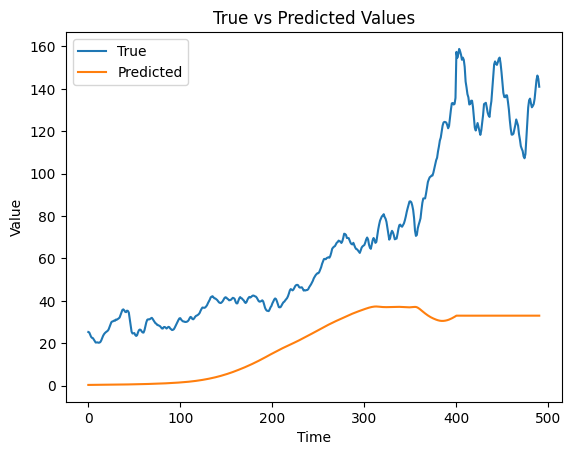

epoch:  1 loss:  0.7764185412228107 test loss:  0.7915617175154633


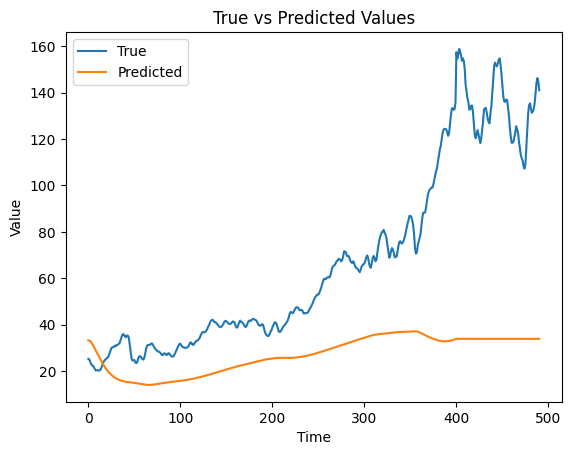

KeyboardInterrupt: 

In [5]:
from graph_model import TempGNN
from tqdm.notebook import tqdm
from torch_geometric.nn import GCNConv, GINConv
from torch_geometric.nn.models import GIN


# seed 
torch.manual_seed(2024)

devce = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

model = TempGNN(input_length=window_size, temp_emb_dim=32, mpnn=GIN, emb_class="LSTM").to(devce)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
edge_index = torch.nonzero(torch.tensor(adj)).t().contiguous().to(devce)


def loss_fn(output, target, epsilon=1e-8):
    """
    计算平均相对误差损失
    output: 模型的预测输出
    target: 真实的目标值
    注意: 确保 target 中没有零值，因为会导致除以零的错误。
    """
    relative_errors = torch.abs((output - target) / (target+epsilon))
    return torch.mean(relative_errors)

# def loss_fn(y_pred, y_true):
#     return F.mse_loss(y_pred, y_true)

model.train()
for epoch in range(15):
    y_history = {'true':[], 'pred':[]}
    total_loss = 0
    # for x, y in tqdm(train_loader):
    for i, (x, y)in enumerate(train_loader):
        x, y = x.to(devce), y.to(devce)
        
        optimizer.zero_grad()
        # print(x.shape, y.shape)
        y_mean = torch.mean(y, dim=2)
        # y_logvar = torch.log(torch.var(y, dim=1))
        # make edge_index batched
        # edge_index_batched = edge_index.repeat(x.shape[0], 1)
        y_pred = model(x, edge_index)
        loss = loss_fn(y_pred, y_mean)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        y_history['true'].append(y_mean[0][0].item())
        y_history['pred'].append(y_pred[0][0].item())
    
    total_loss_test = 0
    # for x, y in tqdm(test_loader):
    for x, y in test_loader:
        x, y = x.to(devce), y.to(devce)
        y_mean = torch.mean(y, dim=2)
        y_pred = model(x, edge_index)
        loss = loss_fn(y_pred, y_mean)
        total_loss_test += loss.item()
        y_history['true'].append(y_mean[0][0].item())
        y_history['pred'].append(y_pred[0][0].item())
    
    print('epoch: ', epoch, 'loss: ', total_loss / len(train_loader), 'test loss: ', total_loss_test / len(test_loader))
    import matplotlib.pyplot as plt
    # Plot the true and predicted values
    # plt.figure(figsize=(10, 6))
    plt.plot(y_history['true'], label='True')
    plt.plot(y_history['pred'], label='Predicted')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('True vs Predicted Values')
    plt.legend()
    plt.show()



        

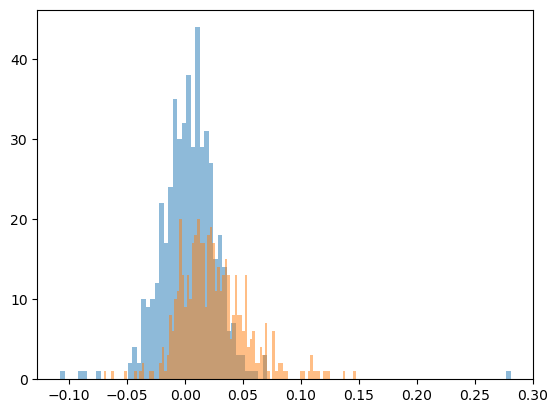

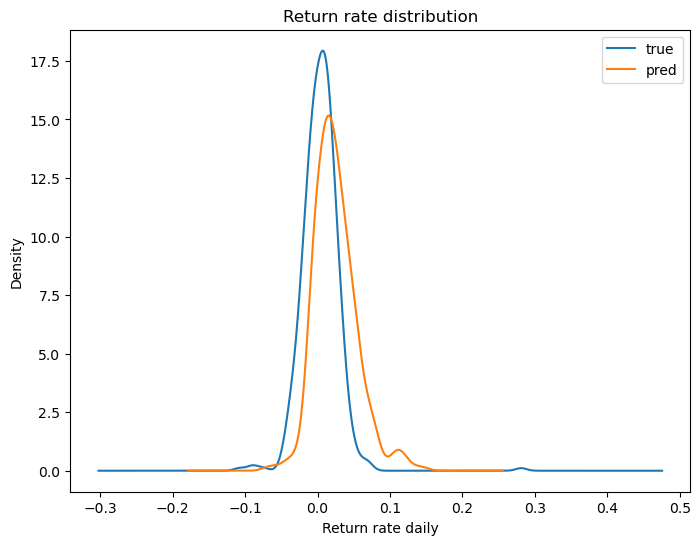

In [ ]:
import pandas as pd
true_df = pd.DataFrame(y_history['true'])
pred_df = pd.DataFrame(y_history['pred'])
# pcnt change
true_df = true_df.pct_change()
pred_df = pred_df.pct_change()
true_df = true_df.dropna()
pred_df = pred_df.dropna()

# sliding window
window_size = 15
# true_df = true_df.rolling(window=window_size).mean()
pred_df = pred_df.rolling(window=window_size).mean()

# return distribution
plt.hist(true_df[0], bins=100, alpha=0.5, label='true')
plt.hist(pred_df[0], bins=100, alpha=0.5, label='pred')

# density plot in one figure
plt.figure(figsize=(8, 6))
true_df[0].plot.kde(label='true')
pred_df[0].plot.kde(label='pred')
plt.xlabel('Return rate daily')
plt.ylabel('Density')
plt.title('Return rate distribution')


plt.legend()
plt.show()


In [17]:
from torch_geometric.explain import Explainer,GNNExplainer
# from my_gnn_explainer import GNNExplainer

# x = np.random.randn(num_nodes,time_len)
# # generate edge index random
# edge_index = np.random.randint(0,num_nodes,(2,10))
# edge_index = torch.tensor(edge_index)
# x = torch.tensor(x).float()

# node_idx = 0
x, y = test_dataset[0]
x = x.to(devce)

explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type=None,
    edge_mask_type='object',
    model_config=dict(
        mode='regression',
        task_level='node',
        return_type='raw',
    ),
)
node_index = 415

explanation = explainer(x, edge_index, index=node_index)
print(f'Generated explanations in {explanation.available_explanations}')

# path = 'feature_importance.png'
# explanation.visualize_feature_importance(path, top_k=10)
# print(f"Feature importance plot has been saved to '{path}'")

path = 'subgraph.pdf'
explanation.visualize_graph(path)
# print(f"Subgraph visualization plot has been saved to '{path}'")
names = stock_dataset.get_names()
explanation.visualize_graph(backend='graphviz')

Generated explanations in ['edge_mask']


In [13]:
explanation.edge_mask

tensor([0.0000, 0.8425, 0.8259,  ..., 0.0000, 0.0000, 0.0000], device='mps:0')

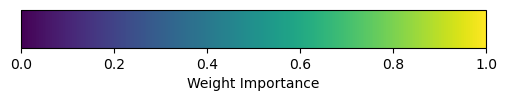

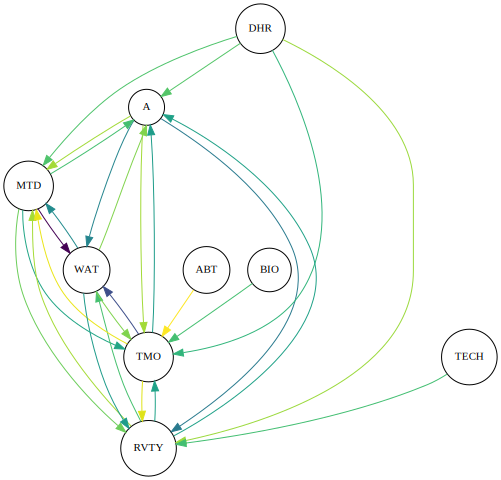

In [25]:
import my_visualize_graph
from my_visualize_graph import visualize_graph
# reimport visualize_graph
from importlib import reload
reload(my_visualize_graph)


import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

cmap = cm.get_cmap('viridis')
norm = matplotlib.colors.Normalize(vmin=0, vmax=1)

cb = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap,
                                      norm=norm,
                                      orientation='horizontal')
cb.set_label('Weight Importance')
plt.show()

visualize_graph(edge_index=edge_index, edge_weight=explanation.edge_mask, backend='graphviz',
                node_labels=names)
